In [160]:
# imports
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import pickle
import community as community_louvain  # pip install python-louvain
from collections import defaultdict


In [161]:
# Extract the dataframe (aggregated)
path1 = "../dataframes/df_aggregated.pk1"
with open(path1, "rb") as f:
    df = pickle.load(f)


# Build similarity matrix

### Using Cosine similarity
The goal is to measure the direct similarity between diseases based on their symptom vectors (or features),

In [162]:
# Get disease names
diseases = df.iloc[:, 0]


In [163]:
# Extract symptom matrix 
symptom_matrix = df.iloc[:, 1:].values  

# Check dimensions
print("Number of diseases:", len(diseases))
print("Number of symptoms:", symptom_matrix.shape[1])
print("Symptom matrix shape:", symptom_matrix.shape)

Number of diseases: 773
Number of symptoms: 377
Symptom matrix shape: (773, 377)


In [164]:
# Compute cosine similarity matrix
cosine_sim_matrix = cosine_similarity(symptom_matrix)

In [165]:
# Convert similarity matrix to df
cosine_df = pd.DataFrame(cosine_sim_matrix, index=diseases, columns=diseases)
print("Cosine Similarity Matrix:\n", cosine_df)

Cosine Similarity Matrix:
 diseases                   abdominal aortic aneurysm  abdominal hernia  \
diseases                                                                 
abdominal aortic aneurysm                   1.000000          0.129099   
abdominal hernia                            0.129099          1.000000   
abscess of nose                             0.000000          0.000000   
abscess of the lung                         0.204124          0.000000   
abscess of the pharynx                      0.000000          0.000000   
...                                              ...               ...   
white blood cell disease                    0.136083          0.105409   
whooping cough                              0.182574          0.000000   
wilson disease                              0.000000          0.000000   
yeast infection                             0.136083          0.105409   
zenker diverticulum                         0.000000          0.000000   

diseases  

In [166]:
# Set diagonal values to 0 (self-similarity)
np.fill_diagonal(cosine_sim_matrix, 0)

# Find max similarity value (off-diagonal)
max_sim = np.max(cosine_sim_matrix)

# Find disease pairs with max similarity
max_pairs = np.argwhere(cosine_sim_matrix == max_sim)


In [167]:
# Extract upper triangle (to avoid duplicate pairs)
upper_triangle_indices = np.triu_indices_from(cosine_sim_matrix, k=1)

# Get disease pairs and similarity scores
similarity_scores = cosine_sim_matrix[upper_triangle_indices]
disease_pairs = [(diseases[i], diseases[j]) for i, j in zip(*upper_triangle_indices)]

# df disease pairs and similarities
similarity_df = pd.DataFrame(disease_pairs, columns=["Disease 1", "Disease 2"])
similarity_df["Cosine Similarity"] = similarity_scores


In [168]:
# Show similarity df
similarity_df

,Disease 1,Disease 2,Cosine Similarity
0,abdominal aortic aneurysm,abdominal hernia,0.129099
1,abdominal aortic aneurysm,abscess of nose,0.000000
2,abdominal aortic aneurysm,abscess of the lung,0.204124
3,abdominal aortic aneurysm,abscess of the pharynx,0.000000
4,abdominal aortic aneurysm,acanthosis nigricans,0.000000
...,...,...,...
298373,whooping cough,yeast infection,0.000000
298374,whooping cough,zenker diverticulum,0.258199
298375,wilson disease,yeast infection,0.000000
298376,wilson disease,zenker diverticulum,0.000000


### View top 50 similar diseases

In [169]:
# Get top 50 similar diseases
top_50_similar = similarity_df.sort_values(by="Cosine Similarity", ascending=False).head(50)

In [170]:
top_50_similar

,Disease 1,Disease 2,Cosine Similarity
128725,dislocation of the knee,dislocation of the patella,1.000000
260429,open wound of the finger,open wound of the hand,1.000000
190131,heart contusion,kaposi sarcoma,1.000000
106541,corneal disorder,dry eye of unknown cause,0.953463
119683,depression,post-traumatic stress disorder (ptsd),0.953463
291476,skin disorder,skin polyp,0.953463
217081,infectious gastroenteritis,noninfectious gastroenteritis,0.916667
290006,seborrheic keratosis,skin polyp,0.909091
284544,psychotic disorder,schizophrenia,0.909091
232878,kidney stone,pyelonephritis,0.909091


## Agglomerative hierarchical clustering (AHC)
Hierarchical clustering iteratively identifies groups of nodes with high similarity.
Agglomerative algorithms merge nodes and communities with high similarity. 

Steps:

Start with individual diseases as separate clusters.

Calculate distances between each disease using cosine distance (1 - similarity).

Iteratively merge the closest clusters using Ward’s method (this essentially minimized variance).

Continue merging until a single cluster remains.

Visualize the clustering structure in a dendrogram.


In [171]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [172]:
# Extract disease pairs and their cosine similarity values
disease_pairs = top_50_similar[['Disease 1', 'Disease 2']].values
similarity_values = top_50_similar['Cosine Similarity'].values

In [173]:
# Create a disease list from the top 50 pairs (unique diseases)
diseases_list = np.unique(disease_pairs)

In [174]:
# Create a zero matrix for the similarity values between diseases
similarity_matrix = np.zeros((len(diseases_list), len(diseases_list)))

In [175]:
# Fill in the similarity values from top_50_similar
for (disease_1, disease_2), similarity in zip(disease_pairs, similarity_values):
    idx1 = np.where(diseases_list == disease_1)[0][0]
    idx2 = np.where(diseases_list == disease_2)[0][0]
    similarity_matrix[idx1, idx2] = similarity
    similarity_matrix[idx2, idx1] = similarity  # Symmetric matrix

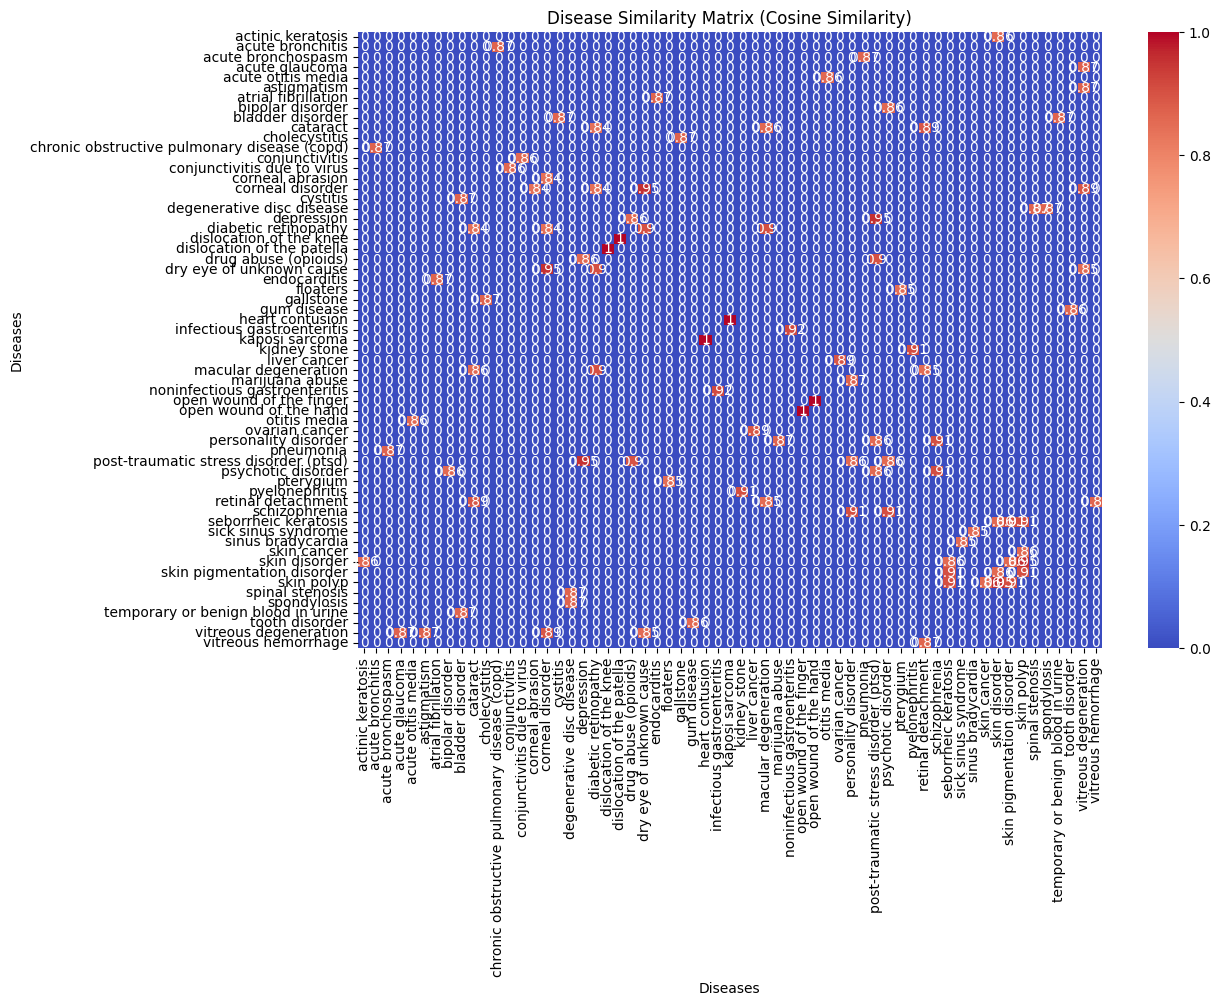

In [176]:
plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix, xticklabels=diseases_list, yticklabels=diseases_list, cmap='coolwarm', annot=True)
plt.title("Disease Similarity Matrix (Cosine Similarity)")
plt.xlabel("Diseases")
plt.ylabel("Diseases")
plt.show()

Complete linkage, while useful for specific cases, tends to produce more stretched out clusters and is more sensitive to outliers, which can make it less desirable in many real-world clustering scenarios.

But Wards helps us combine things more into compact, well-separted clusters.

In [177]:
distance_matrix = 1 - similarity_matrix  # Cosine distance = 1 - cosine similarity

Z = linkage(distance_matrix, method='ward') #  compact and distinct group
# Z = linkage(distance_matrix, method='complete') # strict separation of diseases

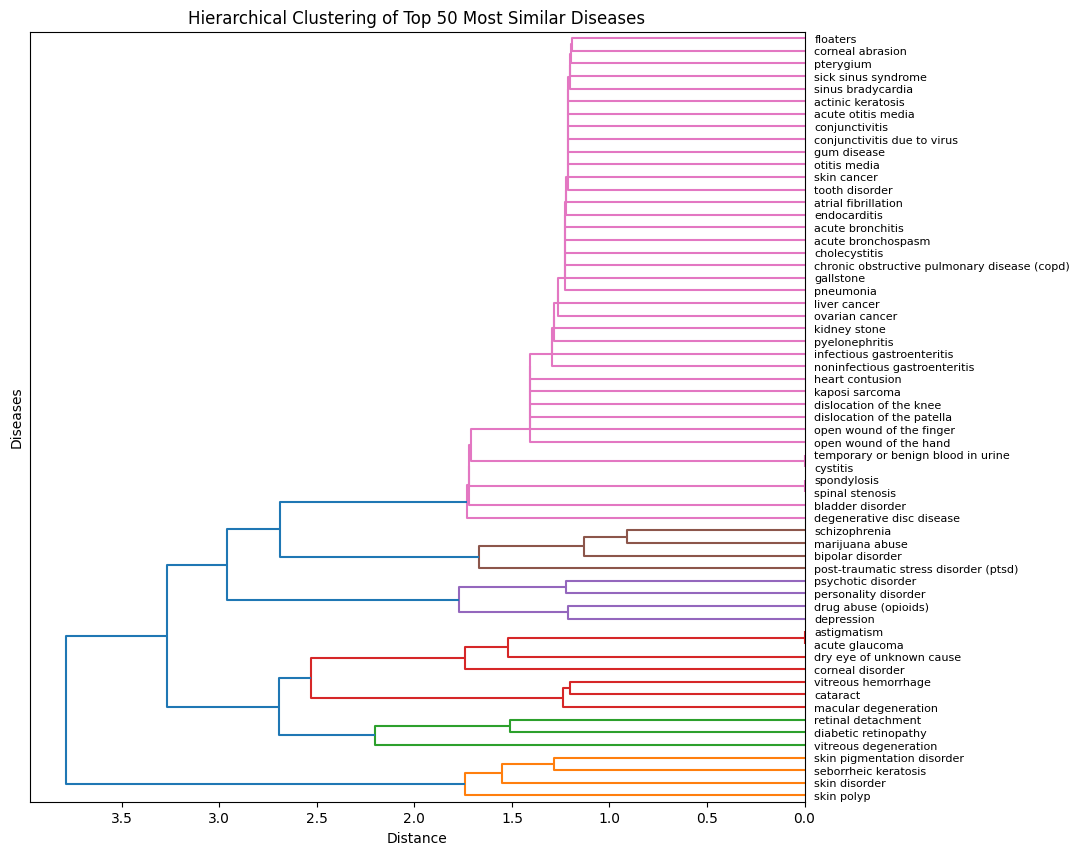

In [178]:
plt.figure(figsize=(10, 10))
dendrogram(Z, labels=diseases_list, leaf_rotation=90, leaf_font_size=8, orientation='left')

plt.title("Hierarchical Clustering of Top 50 Most Similar Diseases")
plt.ylabel("Diseases")  # y-axis label
plt.xlabel("Distance")  # x-axis label

# Make the y-axis labels horizontal
plt.yticks(rotation=0)  # 0 means horizontal labels
plt.show()

## Community analysis using Louivain's algorithm

In [179]:
# Convert the partition dictionary into clusters
from collections import defaultdict
import csv

In [180]:
disease_pairs = similarity_df[['Disease 1', 'Disease 2']].values
similarity_values = similarity_df['Cosine Similarity'].values

In [181]:
# Create edge list for Gephi (Source, Target, Weight)
edge_list = []
for (disease_1, disease_2), similarity in zip(disease_pairs, similarity_values):
    if similarity > 0:  # Only include edges with similarity > 0
        edge_list.append([disease_1, disease_2, similarity])

edge_df = pd.DataFrame(edge_list, columns=["Source", "Target", "Weight"])
edge_df.to_csv("disease_similarity_edge_list.csv", index=False)

In [182]:
# Create a graph from the edge list
G = nx.Graph()
for (disease_1, disease_2), similarity in zip(disease_pairs, similarity_values):
    if similarity > 0:
        G.add_edge(disease_1, disease_2, weight=similarity)

In [183]:
# Apply Louvain
partition = community_louvain.best_partition(G, weight='weight')


In [184]:
# Create a node list with correct ID and Label format
# Create a mapping of diseases to unique indices
disease_to_index = {disease: idx for idx, disease in enumerate(G.nodes())}

In [185]:
# Create a node list with unique ID, disease name, and community ID
node_list = []
for disease, community_id in partition.items():
    node_list.append([disease_to_index[disease], disease, community_id])  # Use unique index as ID


In [186]:
# Convert to DataFrame and save node list
node_df = pd.DataFrame(node_list, columns=["Id", "Label", "Community"])
node_df.to_csv("disease_nodes_with_communities.csv", index=False)

In [187]:
num_communities = len(set(partition.values()))
print(f"Number of Communities: {num_communities}")

Number of Communities: 7


In [188]:
# Create a dictionary to group diseases by community
community_groups = defaultdict(list)
for disease, community_id in partition.items():
    community_groups[community_id].append(disease)

# Open a file in write mode to save the communities and their diseases
with open("diseases_per_community.txt", "w") as f:
    for community_id, diseases in community_groups.items():
        f.write(f"Community {community_id}:\n")
        for disease in diseases:
            f.write(f"  - {disease}\n")
        f.write("\n")  # Add an empty line between communities for readability

# Optional: Print the output to the notebook as well
with open("diseases_per_community.txt", "r") as f:
    print(f.read())

Community 2:
  - abdominal aortic aneurysm
  - abdominal hernia
  - acute fatty liver of pregnancy (aflp)
  - acute kidney injury
  - acute pancreatitis
  - adrenal adenoma
  - alcoholic liver disease
  - anal fissure
  - appendicitis
  - ascending cholangitis
  - benign kidney cyst
  - benign vaginal discharge (leukorrhea)
  - bladder disorder
  - celiac disease
  - cervical disorder
  - cervicitis
  - chlamydia
  - cholecystitis
  - choledocholithiasis
  - chronic constipation
  - chronic pancreatitis
  - cirrhosis
  - colonic polyp
  - colorectal cancer
  - crohn disease
  - cystitis
  - diabetic ketoacidosis
  - diverticulitis
  - diverticulosis
  - drug withdrawal
  - ectopic pregnancy
  - endometriosis
  - epididymitis
  - esophageal cancer
  - esophagitis
  - fluid overload
  - foreign body in the gastrointestinal tract
  - gallstone
  - gas gangrene
  - gastritis
  - gastroduodenal ulcer
  - gastroesophageal reflux disease (gerd)
  - gastrointestinal hemorrhage
  - gastroparesi

In [189]:
# Create a mapping of diseases to unique indices
disease_to_index = {disease: idx for idx, disease in enumerate(G.nodes())}

# Compute degrees
degree_dict = dict(G.degree())

# Dictionary of diseases by community 
# community_groups = defaultdict(list)
for disease, community_id in partition.items():
    community_groups[community_id].append(disease)



In [190]:
# Store top 4-5 highest-degree nodes per community
top_nodes_per_community = []

for community_id, diseases_in_community in community_groups.items():
    if len(diseases_in_community) > 1:  # Only consider meaningful communities
        # Sort diseases by degree in descending order
        sorted_diseases = sorted(diseases_in_community, key=lambda d: degree_dict.get(d, 0), reverse=True)
        # Take the top 4 or 5 (if at least 5 exist)
        top_diseases = sorted_diseases[:5]

        for disease in top_diseases:
            top_nodes_per_community.append([
                community_id,
                disease_to_index[disease], 
                disease, 
                degree_dict[disease]
            ])

# Convert to DataFrame and save
top_nodes_df = pd.DataFrame(top_nodes_per_community, columns=["Community", "Id", "Label", "Degree"])
top_nodes_df.to_csv("top_degree_nodes_per_community.csv", index=False)

# Create edge list with IDs
edge_list = []
for (disease_1, disease_2), similarity in zip(disease_pairs, similarity_values):
    if similarity > 0:
        edge_list.append([
            disease_to_index[disease_1],  # Convert Source to ID
            disease_to_index[disease_2],  # Convert Target to ID
            similarity
        ])

# Convert to DataFrame and save
edge_df = pd.DataFrame(edge_list, columns=["Source", "Target", "Weight"])
edge_df.to_csv("disease_similarity_edge_list.csv", index=False)

In [191]:
edge_df

,Source,Target,Weight
0,0,1,0.129099
1,0,2,0.204124
2,0,3,0.117851
3,0,4,0.117851
4,0,5,0.123091
...,...,...,...
67035,270,271,0.298142
67036,270,413,0.192450
67037,270,272,0.111111
67038,271,413,0.258199


In [200]:
# Save the highest-degree nodes per community in a .txt file
with open("top_degree_nodes_per_community.txt", "w") as f:
    for community_id, diseases_in_community in community_groups.items():
        if len(diseases_in_community) > 1:  # Only consider meaningful communities
            sorted_diseases = sorted(diseases_in_community, key=lambda d: degree_dict.get(d, 0), reverse=True)
            top_diseases = sorted_diseases[:10]  # Get top 4-5 nodes

            f.write(f"Community {community_id}:\n")
            for disease in top_diseases:
                f.write(f"  - {disease} (Degree: {degree_dict[disease]})\n")
            f.write("\n")  # Add spacing between communities

In [193]:
# Print all nodes per community in Jupyter Notebook & save to .txt
with open("all_nodes_per_community.txt", "w") as f:
    for community_id, diseases_in_community in community_groups.items():
        print(f"\nCommunity {community_id}:")  # Print in Jupyter Notebook
        f.write(f"Community {community_id}:\n")  # Write to .txt file

        for disease in sorted(diseases_in_community):  # Sort for readability
            print(f"  - {disease}")  # Print in Jupyter
            f.write(f"  - {disease}\n")  # Write to .txt file

        print("\n" + "-"*40)  # Separator in Jupyter
        f.write("\n" + "-"*40 + "\n")  # Separator in .txt file



Community 2:
  - abdominal aortic aneurysm
  - abdominal aortic aneurysm
  - abdominal hernia
  - abdominal hernia
  - acute fatty liver of pregnancy (aflp)
  - acute fatty liver of pregnancy (aflp)
  - acute kidney injury
  - acute kidney injury
  - acute pancreatitis
  - acute pancreatitis
  - adrenal adenoma
  - adrenal adenoma
  - alcoholic liver disease
  - alcoholic liver disease
  - anal fissure
  - anal fissure
  - anal fistula
  - anal fistula
  - appendicitis
  - appendicitis
  - ascending cholangitis
  - ascending cholangitis
  - atonic bladder
  - atonic bladder
  - atrophic vaginitis
  - atrophic vaginitis
  - benign kidney cyst
  - benign kidney cyst
  - benign prostatic hyperplasia (bph)
  - benign prostatic hyperplasia (bph)
  - benign vaginal discharge (leukorrhea)
  - benign vaginal discharge (leukorrhea)
  - bladder cancer
  - bladder cancer
  - bladder disorder
  - bladder disorder
  - bladder obstruction
  - bladder obstruction
  - carcinoid syndrome
  - carcinoid

In [194]:
# Create a dictionary mapping disease to community
disease_to_community = partition

# Group edges (disease pairs) by community (only if both diseases are in the same community)
intra_community_edges = defaultdict(list)

for (d1, d2), sim in zip(disease_pairs, similarity_values):
    if sim > 0:
        comm1 = disease_to_community.get(d1)
        comm2 = disease_to_community.get(d2)
        if comm1 == comm2:  # Only keep pairs within the same community
            intra_community_edges[comm1].append((d1, d2, sim))

# For each community, sort by similarity and take top 5 pairs
top_similar_pairs_per_community = []

for community_id in sorted(intra_community_edges.keys()):  # ascending order of community
    pairs = intra_community_edges[community_id]
    sorted_pairs = sorted(pairs, key=lambda x: x[2], reverse=True)  # Sort by similarity descending
    top_pairs = sorted_pairs[:5]  # Top 5 most similar pairs

    for d1, d2, sim in top_pairs:
        top_similar_pairs_per_community.append({
            "Community": community_id,
            "Disease 1": d1,
            "Disease 2": d2,
            "Similarity": sim
        })

# Convert to DataFrame and save, sorted by Community (just in case)
top_pairs_df = pd.DataFrame(top_similar_pairs_per_community)
top_pairs_df.sort_values(by="Community", inplace=True)
top_pairs_df.to_csv("top_misdiagnosis_pairs_per_community.csv", index=False)


In [195]:
top_similar_pairs_per_community

[{'Community': 0,
  'Disease 1': 'heart contusion',
  'Disease 2': 'kaposi sarcoma',
  'Similarity': np.float64(0.9999999999999998)},
 {'Community': 0,
  'Disease 1': 'depression',
  'Disease 2': 'post-traumatic stress disorder (ptsd)',
  'Similarity': np.float64(0.9534625892455926)},
 {'Community': 0,
  'Disease 1': 'personality disorder',
  'Disease 2': 'schizophrenia',
  'Similarity': np.float64(0.9090909090909093)},
 {'Community': 0,
  'Disease 1': 'psychotic disorder',
  'Disease 2': 'schizophrenia',
  'Similarity': np.float64(0.9090909090909093)},
 {'Community': 0,
  'Disease 1': 'drug abuse (opioids)',
  'Disease 2': 'post-traumatic stress disorder (ptsd)',
  'Similarity': np.float64(0.8999999999999999)},
 {'Community': 1,
  'Disease 1': 'skin disorder',
  'Disease 2': 'skin polyp',
  'Similarity': np.float64(0.9534625892455926)},
 {'Community': 1,
  'Disease 1': 'seborrheic keratosis',
  'Disease 2': 'skin pigmentation disorder',
  'Similarity': np.float64(0.9090909090909093)},

In [196]:
top_pairs_df

,Community,Disease 1,Disease 2,Similarity
0,0,heart contusion,kaposi sarcoma,1.000000
1,0,depression,post-traumatic stress disorder (ptsd),0.953463
2,0,personality disorder,schizophrenia,0.909091
3,0,psychotic disorder,schizophrenia,0.909091
4,0,drug abuse (opioids),post-traumatic stress disorder (ptsd),0.900000
9,1,actinic keratosis,skin disorder,0.858116
7,1,seborrheic keratosis,skin polyp,0.909091
8,1,skin pigmentation disorder,skin polyp,0.909091
5,1,skin disorder,skin polyp,0.953463
6,1,seborrheic keratosis,skin pigmentation disorder,0.909091


In [197]:
# Print all nodes per community in Jupyter Notebook & save to .txt
with open("all_nodes_per_community.txt", "w") as f:
    for community_id, diseases_in_community in community_groups.items():
        print(f"\nCommunity {community_id}:")  # Print in Jupyter Notebook
        f.write(f"Community {community_id}:\n")  # Write to .txt file

        for disease in sorted(diseases_in_community):  # Sort for readability
            print(f"  - {disease}")  # Print in Jupyter
            f.write(f"  - {disease}\n")  # Write to .txt file

        print("\n" + "-"*40)  # Separator in Jupyter
        f.write("\n" + "-"*40 + "\n")  # Separator in .txt file



Community 2:
  - abdominal aortic aneurysm
  - abdominal aortic aneurysm
  - abdominal hernia
  - abdominal hernia
  - acute fatty liver of pregnancy (aflp)
  - acute fatty liver of pregnancy (aflp)
  - acute kidney injury
  - acute kidney injury
  - acute pancreatitis
  - acute pancreatitis
  - adrenal adenoma
  - adrenal adenoma
  - alcoholic liver disease
  - alcoholic liver disease
  - anal fissure
  - anal fissure
  - anal fistula
  - anal fistula
  - appendicitis
  - appendicitis
  - ascending cholangitis
  - ascending cholangitis
  - atonic bladder
  - atonic bladder
  - atrophic vaginitis
  - atrophic vaginitis
  - benign kidney cyst
  - benign kidney cyst
  - benign prostatic hyperplasia (bph)
  - benign prostatic hyperplasia (bph)
  - benign vaginal discharge (leukorrhea)
  - benign vaginal discharge (leukorrhea)
  - bladder cancer
  - bladder cancer
  - bladder disorder
  - bladder disorder
  - bladder obstruction
  - bladder obstruction
  - carcinoid syndrome
  - carcinoid

In [198]:
# Create list to store scored pairs
scored_pairs = []

for idx, row in similarity_df.iterrows():
    d1 = row['Disease 1']
    d2 = row['Disease 2']
    similarity = row['Cosine Similarity']
    
    # Only consider connected pairs with similarity > 0
    if similarity > 0 and G.has_edge(d1, d2):
        deg1 = degree_dict.get(d1, 0)
        deg2 = degree_dict.get(d2, 0)
        avg_deg = (deg1 + deg2) / 2
        misdiagnosis_score = similarity * avg_deg
        
        scored_pairs.append({
            'Disease 1': d1,
            'Disease 2': d2,
            'Similarity': similarity,
            'Degree 1': deg1,
            'Degree 2': deg2,
            'Avg Degree': avg_deg,
            'Misdiagnosis Risk Score': misdiagnosis_score
        })

# Convert to DataFrame
risk_df = pd.DataFrame(scored_pairs)

# Sort by score in descending order
risk_df = risk_df.sort_values(by='Misdiagnosis Risk Score', ascending=False)

# Save or display top results
risk_df.to_csv('misdiagnosis_risk_scores.csv', index=False)
print(risk_df.head(10))  # Show top 10 highest-risk pairs


                        Disease 1  \
48552  infectious gastroenteritis   
38763                   gastritis   
18672               cholecystitis   
2657           acute bronchospasm   
10950                 atelectasis   
2179             acute bronchitis   
4254        acute stress reaction   
47148                 hypovolemia   
3577           acute pancreatitis   
52406                kidney stone   

                                          Disease 2  Similarity  Degree 1  \
48552                 noninfectious gastroenteritis    0.916667       333   
38763                                   hypokalemia    0.700000       363   
18672                                     gallstone    0.870388       302   
2657                                      pneumonia    0.870388       289   
10950                          poisoning due to gas    0.771517       335   
2179   chronic obstructive pulmonary disease (copd)    0.870388       323   
4254                                        anxiety  

In [199]:
risk_df

,Disease 1,Disease 2,Similarity,Degree 1,Degree 2,Avg Degree,Misdiagnosis Risk Score
48552,infectious gastroenteritis,noninfectious gastroenteritis,0.916667,333,333,333.0,305.250000
38763,gastritis,hypokalemia,0.700000,363,403,383.0,268.100000
18672,cholecystitis,gallstone,0.870388,302,299,300.5,261.551678
2657,acute bronchospasm,pneumonia,0.870388,289,307,298.0,259.375707
10950,atelectasis,poisoning due to gas,0.771517,335,327,331.0,255.372044
...,...,...,...,...,...,...,...
34770,fibroadenoma,polycystic ovarian syndrome (pcos),0.144338,39,79,59.0,8.515916
34680,female infertility of unknown cause,vulvar disorder,0.182574,26,66,46.0,8.398413
33297,erectile dysfunction,female infertility of unknown cause,0.141421,86,26,56.0,7.919596
34672,female infertility of unknown cause,prostate cancer,0.158114,26,72,49.0,7.747580
